###**Environment Setup**

In [1]:
!pip uninstall -y numpy scipy -q
!pip install numpy==1.26.4 scipy==1.12.0 -q
!pip install ctgan rdt table_evaluator dython -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 15.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
access 1.1.10.post3 requires scipy>=1.14.1, but you have scipy 1.12.0 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.12.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9

###**Loading Dataset**

In [1]:
import pandas as pd
import numpy as np

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

columns = [
    "age","sex","cp","trestbps","chol","fbs","restecg",
    "thalach","exang","oldpeak","slope","ca","thal","target"
]

data = pd.read_csv(url, names=columns)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


###**Handling Missing Values**

In [2]:
data.replace("?", np.nan, inplace=True)
data = data.dropna()
data = data.astype(float)

print(data.shape)

(297, 14)


###**Converting Target to Binary**

In [3]:
data["target"] = (data["target"] > 0).astype(int)
data["target"].value_counts()

,count
target,
0,160
1,137


###**Categorical vs Continous**

In [4]:
categorical_features = [
    "sex", "cp", "fbs", "restecg",
    "exang", "slope", "ca", "thal", "target"
]

continuous_features = [
    "age", "trestbps", "chol", "thalach", "oldpeak"
]

###**Model Training**

In [20]:
from ctgan import CTGAN

ctgan = CTGAN(
    epochs=800,
    batch_size=500,
    verbose=True
)

ctgan.fit(data, categorical_features)

Gen. (-0.74) | Discrim. (0.06): 100%|██████████| 800/800 [00:26<00:00, 30.75it/s]


###**Generating Synthetic Data**

In [21]:
synthetic_data = ctgan.sample(1000)
synthetic_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,43.692498,1.0,4.0,147.398767,199.291510,0.0,0.0,103.646602,0.0,1.862778,1.0,3.0,7.0,1
1,49.661698,1.0,4.0,135.178651,346.580066,0.0,2.0,97.045150,1.0,0.376843,1.0,1.0,7.0,0
2,43.866015,1.0,4.0,121.453930,329.834457,1.0,0.0,122.193263,0.0,0.267135,3.0,0.0,7.0,0
3,45.041408,1.0,4.0,126.266722,261.575525,0.0,0.0,154.876814,0.0,-0.094433,2.0,0.0,7.0,1
4,63.372874,1.0,2.0,152.273057,317.487262,0.0,0.0,52.923712,1.0,5.934295,2.0,1.0,7.0,1


###**Evaluation**

(297, 14) (1000, 14)


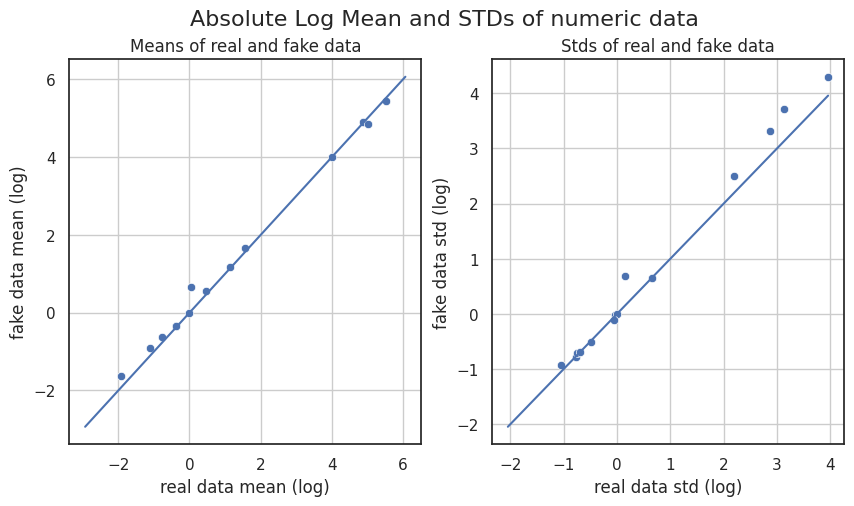

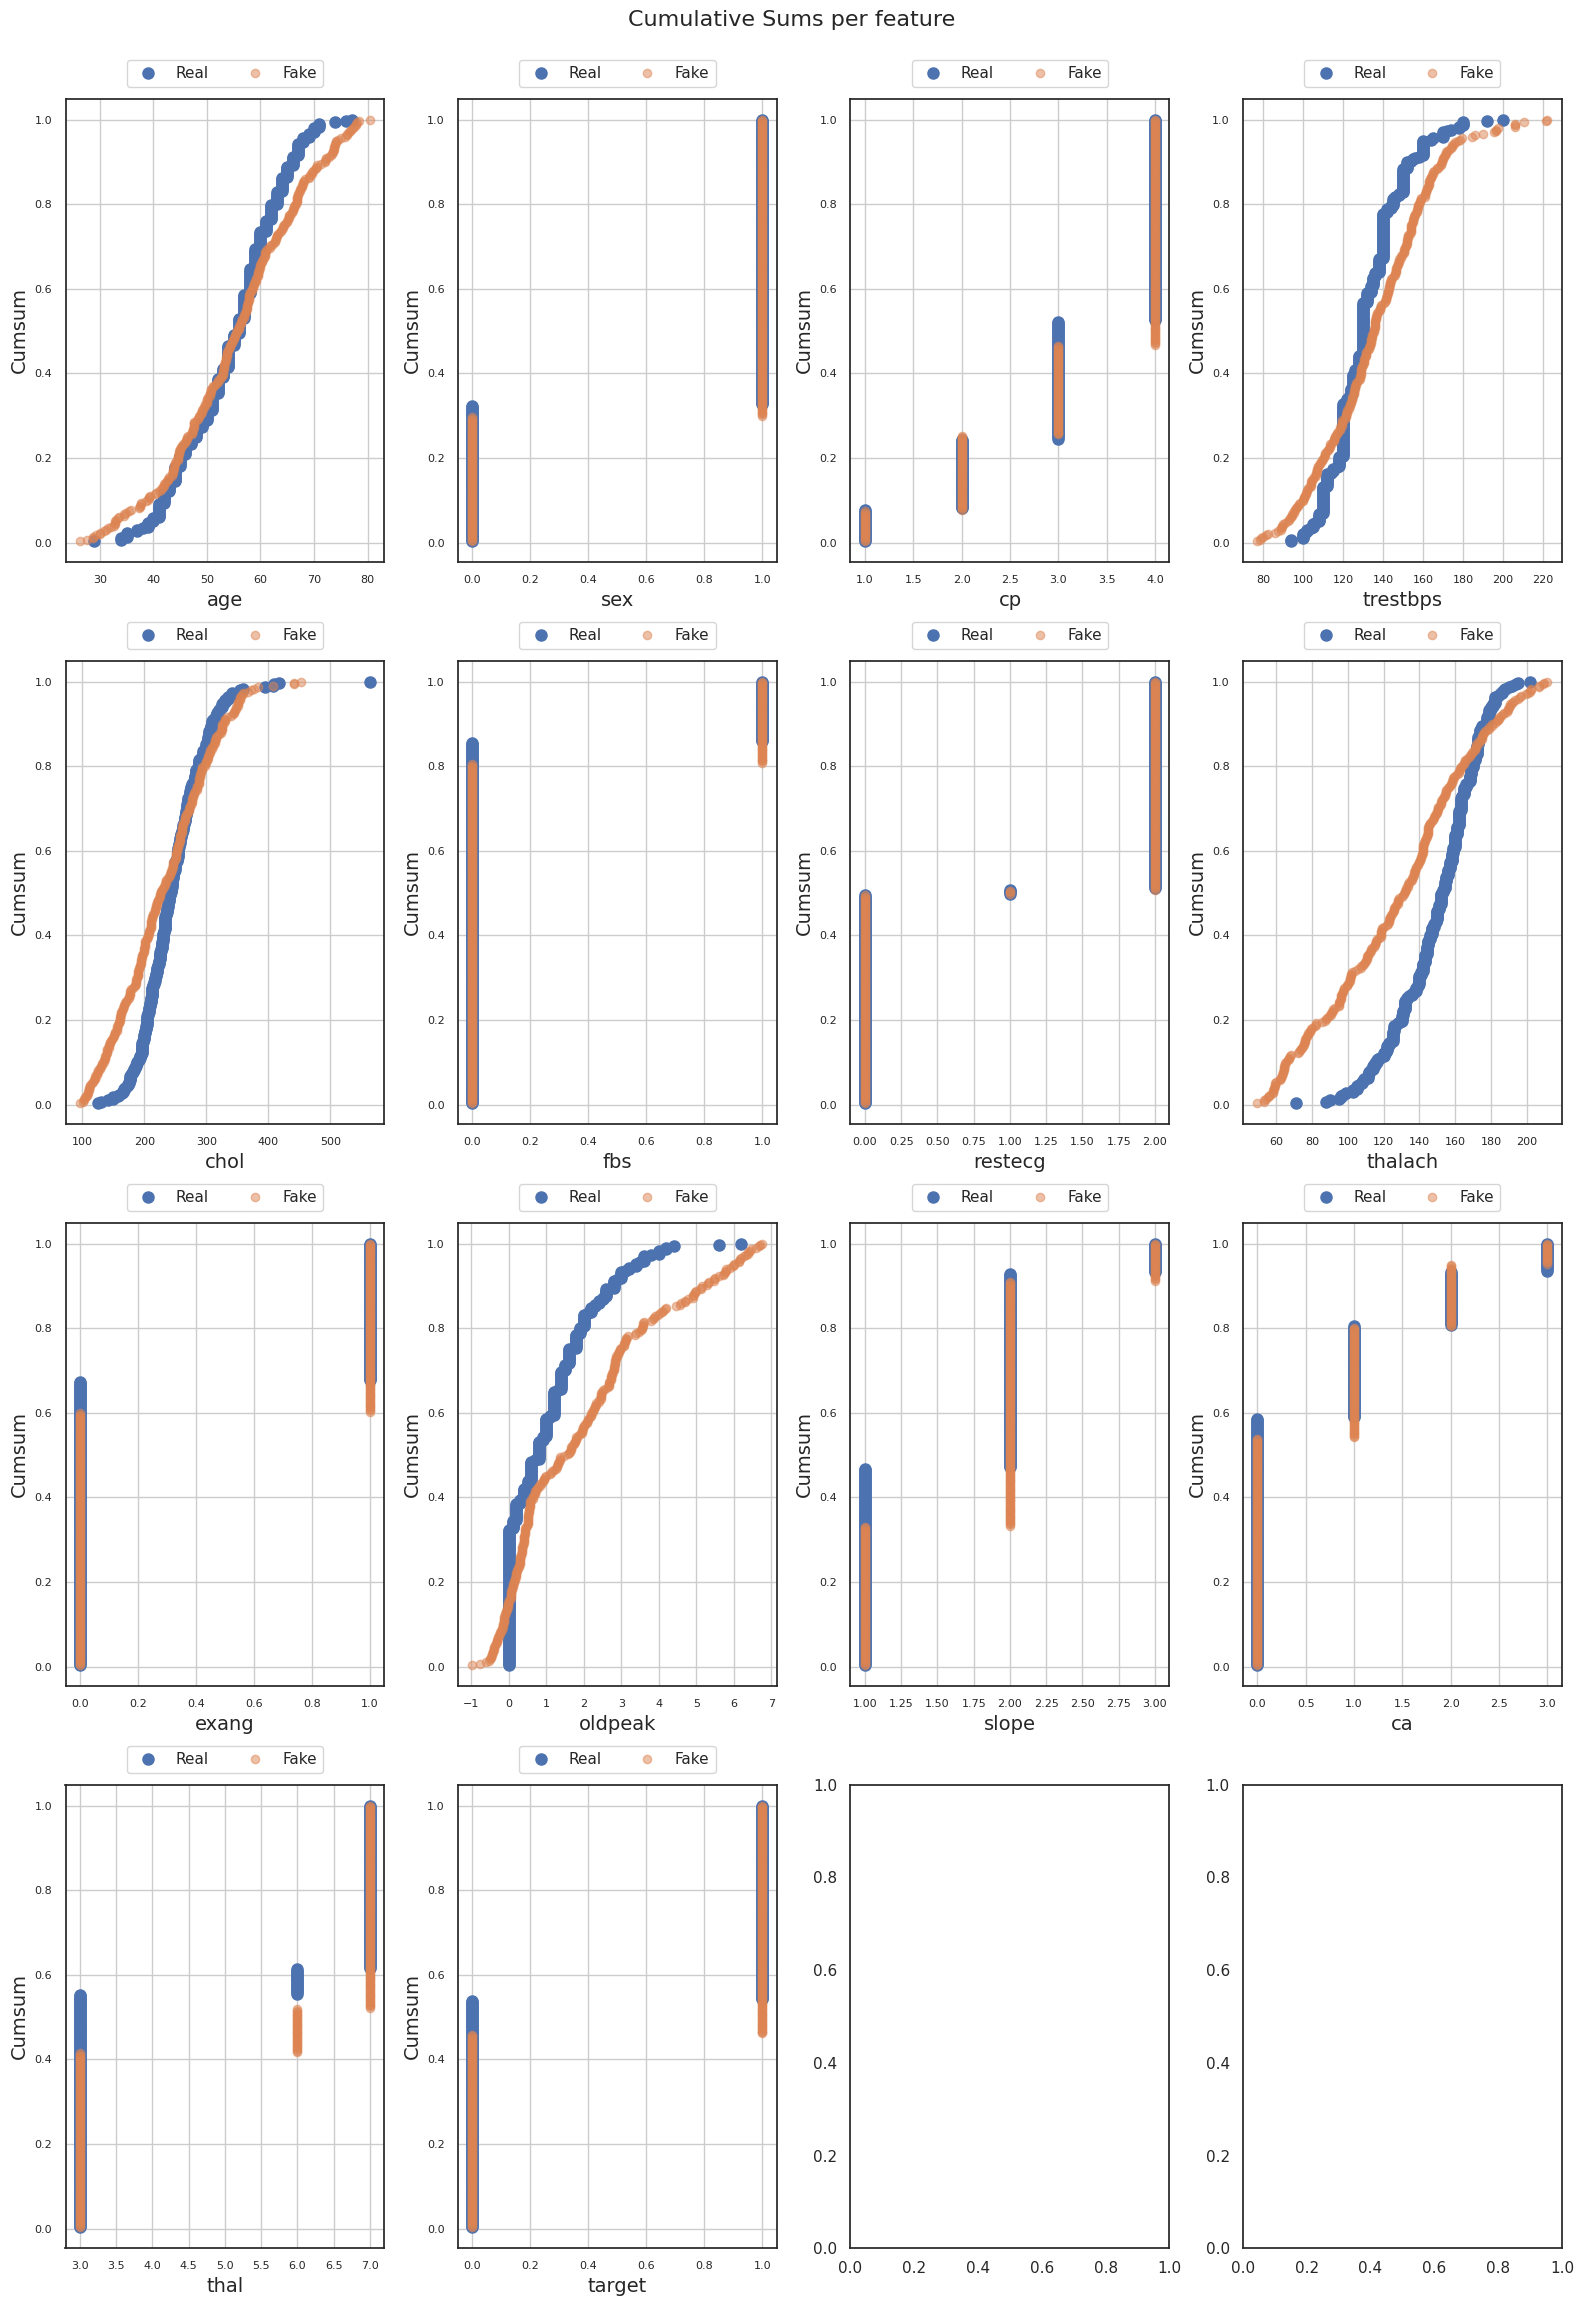

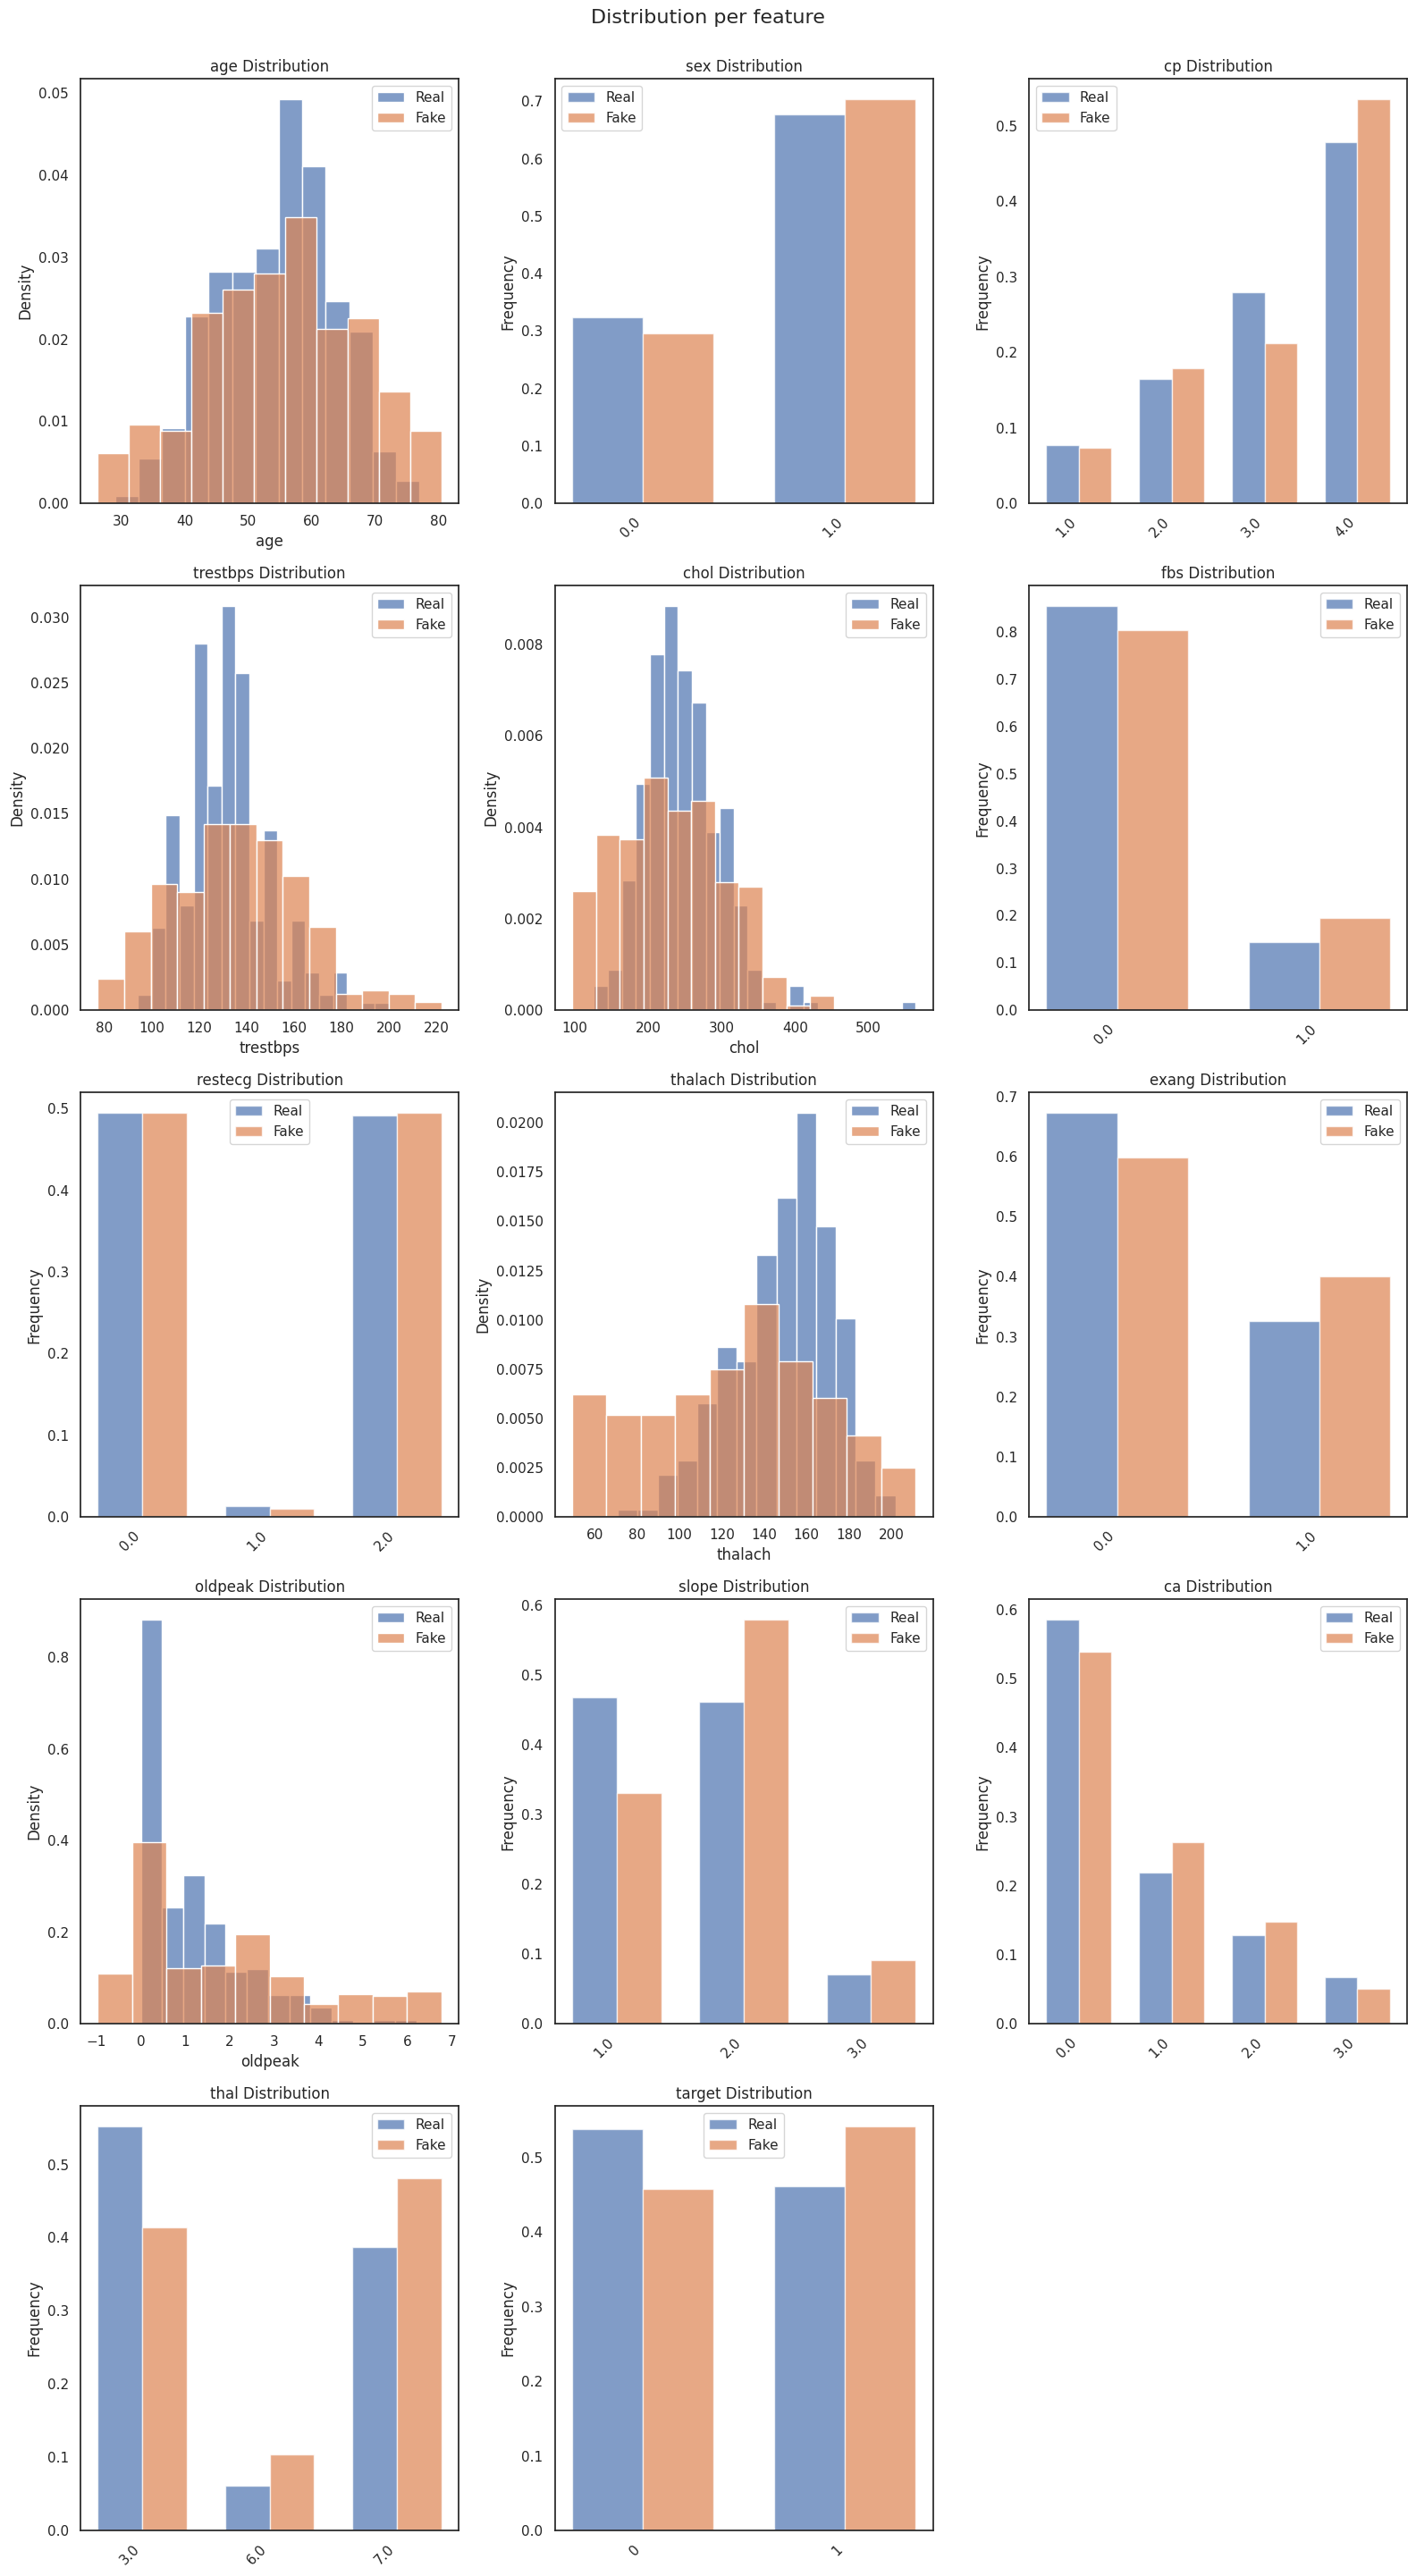

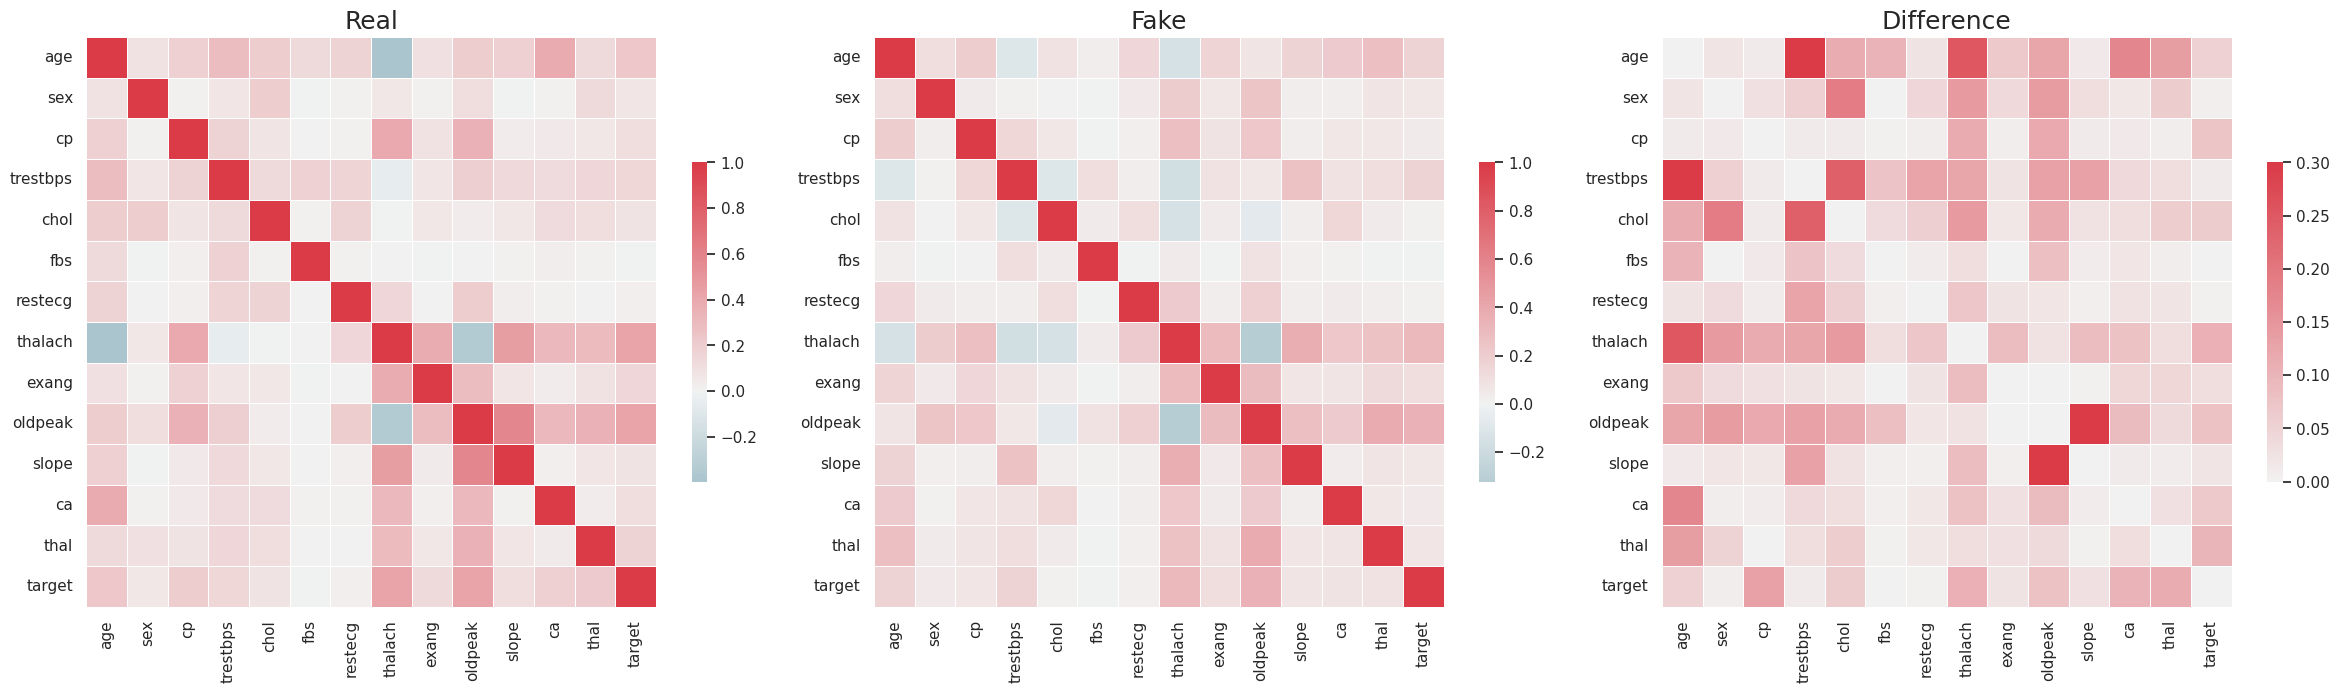

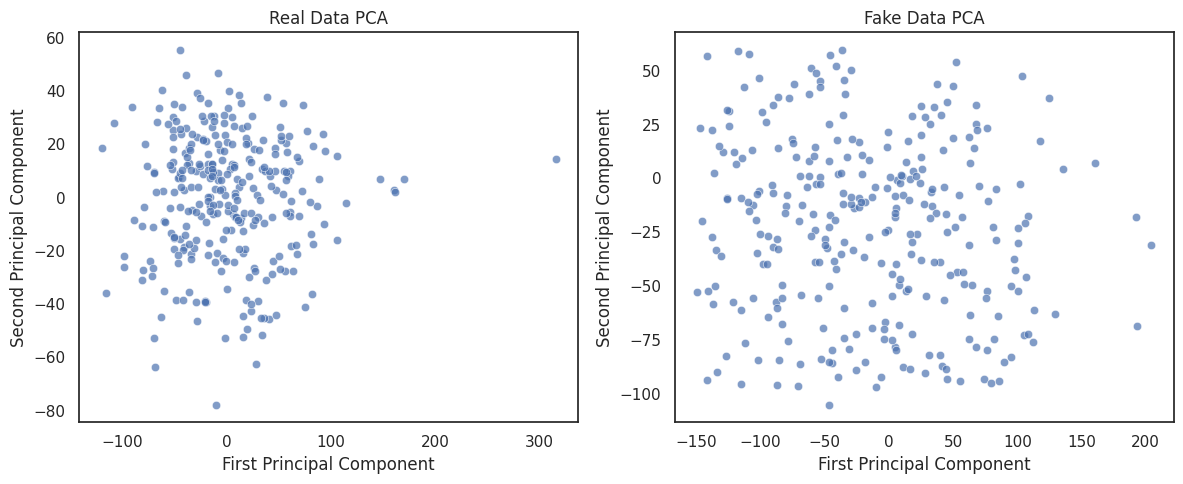

In [22]:
from table_evaluator import TableEvaluator

print(data.shape, synthetic_data.shape)
table_evaluator =  TableEvaluator(data, synthetic_data, cat_cols= categorical_features)

table_evaluator.visual_evaluation()